# Minería de reglas de asociación espacial sobre Minecraft

## El Proyecto

Este proyecto tiene como objetivo la resolución de algún problema en particular y la justificación de la solución utilizando algoritmos de Inteligencia Artificial.

El problema que se eligió para este proyecto se puede explicar de la siguiente manera:

Dentro de la industria de creación de videojuegos existe un area grande e importante que consiste en la generación procedural. Se le llama generación procedural de contenido, o **PCG** (*Procedural Content Generation*) por sus siglas en ingles, a la creación algorítmica de contenido para videojuegos con entradas del usuario limitadas o indirectas. [Procedural Content Generation in Games].
Dentro de este area existen varios algoritmos que permiten la generación de contenido a partir de el establecimiento de parámetros de entrada que permiten al Diseñador orientar el funcionamiento del algoritmo. Teniendo en cuenta esta característica surge la pregunta:  

- ¿Sería posible mediante un algoritmo de inteligencia artificial y un entorno (artificial o natural), poder *inferir* parámetros para que un algoritmo de **PCG** genere entornos similares?  

O de otra manera:

- ¿Puedo ***inferir las relaciones*** que existen entre los objetos de un entorno dado y, a partir de ellos, establecer parámetros para un algoritmo de generación procedural?

Debido a la extension de un proyecto que abarque el procedimiento completo desde la obtención de los datos de un entorno hasta la generación de otro entorno mediante algún algoritmo *PCG* para contestar estas preguntas, se decidió que el enfoque del proyecto este en la búsqueda y comparación de algoritmos de inteligencia artificial que permitan la descripción, aprendizaje o inferencia de las relaciones que existen entre objetos en un espacio natural,artificial,físico o virtual.

Con la exploración bibliográfica se puede entender que existe un area de investigación dentro de la ciencia en minería de datos que enfocada en como realizar las tareas de minería de datos sobre bases de datos espaciales o geográficas. La **Minería de Datos Espaciales** o **SDM** es un proceso de descubrimiento y extracción de conocimiento generalizado sobre gran cantidad de datos espaciales. [Spatial Data Mining_ Theory and Application_Deren L., Shuliang W., Deyi L].

El proyecto entonces consistirá en la aplicación de algunas técnicas y algoritmos utilizados en el area de *Spatial Data Mining* para poder describir u obtener las relaciones entre objetos espaciales en un entorno. Como la obtención de datos de un entorno real, resulta complejo, y el enfoque inicial pretende abstraerse de objetos concretos, se opta por elegir un entorno practico para el proyecto. Concretamente, el entorno es una porción de mapa del Videojuego *Minecraft*.

*Minecraft* es un videojuego con gráficos 3D que utiliza un complejo procedimiento de generación procedural para la creación de terrenos de juego utilizando cubos. Principalmente es elegido debido a que los datos correspondientes a un terreno generado en el videojuego son de fácil acceso, fácil generación y la extracción de es sencilla, además, la disposición de los objetos dentro del juego son bloques con coordenadas rectangulares, es decir que el entorno esta grillado. Se puede obtener mas información sobre el procedimiento de generación procedural en está pagina web: [The World Generation of Minecraft].

### El trabajo

Los enfoques tomados para la *búsqueda de patrones*, según [Discovering Spatial Co-location Patterns],en datos espaciales se dividen en dos ramas:

- Los métodos basados en **estadística espacial** utilizan medidas de correlación espacial para caracterizar las relaciones entre los diferentes tipos de atributos espaciales. Computar las medidas de correlación espacial para todo posible patron de co-localización puede ser computacionalmente caro debido al numero exponencial de candidatos dado una gran cantidad de atributos espaciales.

- El enfoque basado en **reglas de association** se concentra en la creación de transacciones booleanas sobre el espacio de tal manera que se pueda usar el algoritmo ***apriori***.***(Estos son de nuestro interés para la resolución del problema)***

Con la exploración bibliográfica en libros como [Data Mining and Knowledge Discovery Handbook] y [Spatial Data Mining_ Theory and Application_Deren L., Shuliang W., Deyi L] podemos entender que relacionados con la tarea de la minería de datos existen modelos predictivos y descriptivos. Con el análisis del problema entendemos que los modelos con un enfoque descriptivo que podríamos utilizar son los modelos de Clustering o las Reglas de asociación.

En este trabajo optamos por el enfoque mediante un modelo de Reglas de Asociación. Si entendemos un poco más del entorno podemos notar que se encuentra totalmente generado por bloques de distinto tipo y cuyo posicionamiento cumple con un patron que nosotros buscamos descubrir a lo largo del trabajo. Si se utilizara un algoritmo de clustering los resultados que obtendríamos son grupos de bloques que son similares y no es el tipo de respuesta que se busca para la solución al problema.  

Teniendo en cuenta que el resultado esperado es un modelo que permita entender como se relaciona la posición de un bloque con la posición de otro bloque, se eligió el enfoque de Reglas de Asociación que esta basado principalmente en el algoritmo **Apriori**. Por lo tanto en este trabajo se generaran reglas de asociación con este algoritmo y se generaran gráficos que ilustren y permitan el análisis de resultados y obtención de una conclusion.

## Apriori Y Métricas

Con la investigación de la bibliografía sobre el area de Minería de datos espaciales [Spatial Data Mining_ Theory and Application_Deren L., Shuliang W., Deyi L] se nos brinda una definición formal del problema de minar datos transaccionales para generar reglas de asociación.

### Definición formal del problema

Sea $I = \{i_1,...,i_n\}$ un conjunto de *items*. Al conjunto que contiene *k* items se le llama conjunto *k* de items.  

Si $A \subseteq I,B \subseteq I$ y $A \cap B = \empty$, entonces las regla de asociación es una implicación de la forma $A \rightarrow B$.  

$D$ es el conjunto de datos transaccionales relevantes para la tarea de minería.Cada transacción $T$ con un identificador $TID$ es el conjunto permitiendo $T \subseteq I$.  

Un conjunto de items ***frecuente*** es uno donde la frecuencia de ocurrencia de los items no es menor que el **soporte mínimo** establecido y no menor que el numero de transaccionen de $D$.

El algoritmo *Apriori* utiliza información en conjuntos de items *frecuentes* para generar reglas de asociación. La idea básica es buscar en el conjunto de datos transaccionales varias veces para determinar los *conjuntos de items frecuentes*. Cada búsqueda después de la primera, tiene la prioridad de generar conjuntos de datos frecuentes candidato a partir del ultimo conjunto de datos frecuentes obtenido. La información a priori es utilizada para generar el primer conjunto frecuente.

### Métricas

- Soporte: Mide la frecuencia con la que aparece en cada transacción. Se trata de la probabilidad de que aparezca X o Y en las transacciones.
$$
Support({X}\to{Y})  = \dfrac
{\text{Transaction containing X and Y}}
{\text{Total number of transactions}}
$$

- Confianza: Mide la probabilidad de que aparezca el consecuente dado un antecedente.

$$
Confidence({X}\to{Y})  = \dfrac
{\text{Transaction containing X and Y}}
{\text{Transactions containing X}}
$$

- Sustentación: El indicador lift expresa cuál es la proporción del soporte observado de un conjunto de productos respecto del soporte teórico de ese conjunto dado el supuesto de independencia. Un valor de $lift = 1$ indica que ese conjunto aparece una cantidad de veces acorde a lo esperado bajo condiciones de independencia. Un valor de $lift > 1$ indica que ese conjunto aparece una cantidad de veces superior a lo esperado bajo condiciones de independencia (por lo que se puede intuir que existe una relación que hace que los productos se encuentren en el conjunto más veces de lo normal). Un valor de $lift < 1$ indica que ese conjunto aparece una cantidad de veces inferior a lo esperado bajo condiciones de independencia (por lo que se puede intuir que existe una relación que hace que los productos no estén formando parte del mismo conjunto más veces de lo normal).

$$
Lift({X}\to{Y})  = \dfrac{Confidence({X}\to{Y})}{Support({X}\to{Y})}
$$

## Enfoques para el modelado de transacciones

Los problemas de co-localización espacial se ven similares a los clásicos pero de hecho son diferentes debido a la ausencia de transacciones.En el problema de minería de reglas de co-localización espacial, las transacciones son implícitas y además son disjuntos en el sentido de que no comparten instancias de tipos de item. Las instancias de atributos espaciales booleanos están embebidos en el espacio y comparten una variedad de relaciones espaciales unas con otras.

A partir de los los leído en el paper [Discovering Spatial Co-location Patterns], entendemos que en la minería de reglas de asociación existen casos especiales donde al menos uno de los predicados es espacial, lo cual nos lleva a la tarea de minería de reglas de asociación espacial. Si el descubrimiento de reglas de asociación espacial es restringido a un atributo de referencia, entonces las transacciones pueden ser definidas alrededor de instancias de este atributo. Generalizar este paradigma al caso donde no hay un atributo de referencia no es trivial. Una alternativa es la definición de transacciones particionando del espacio, aun que esto puede llevar al descuento de instancias de tuplas que intersecting los limites de las transacciones artificiales o recuentan instancias de tuplas que se encuentran juntas.  

En [Discovering Spatial Co-location Patterns] se definen dos términos para facilitar la descripción de los modelos.

- Una **co-localización** es un subconjunto de atributos espaciales booleanos.

- Una **regla de co-localización** es de la forma $C_1 \rightarrow C_2(p,cp)$ donde $C_1$ y $C_2$ son co-localizaciones, $p$ es un numero representando la medida de predominio y $cp$ es un numero que mide la probabilidad condicionada.

### Modelos para transacciones basadas en co-localización

Con el fin de tomar el conjunto de datos espaciales obtenidos compuesto por coordenadas rectangulares y modificarlos para que sirvan de entrada para el algoritmo **Apriori**. Se pretende utilizar algunos de los modelos siguientes.

#### Modelos

1. **Reference feature centric model**  
Es relevante para aplicaciones enfocadas en un atributo espacial booleano. El modelo enumera los *vecindarios* para "materializar" un conjunto de transacciones al rededor de instancias del atributo espacial de interés.  
Al "materializar" transactions, el **soporte** y la **confianza** de la minería tradicional son usados como *predominio* y medidas de *probabilidad condicionada*.  
![co-location_Image1](../../Images/VecindarioA.png)  
En la imagen lo ques e puede apreciar es que siendo A el atributo de referencia, B y C los atributos relevantes, Entonces por cada atributo A se genera una transacción que depende de los B y los C cercanos o relativos. 
2. **Window centric model**  
Es relevante para aplicaciones que se enfocan en parcelas de territorio. Un objetivo es predecir un conjuntos de atributos espaciales que es probable descubrir en una parcela dado que se han encontrado otros atributos en el. El modelo enumera todas las posibles ventanas como transacciones.En espacios discretizados por grillas uniformes, las ventanas de $kxk$ se pueden materializar ignorando el efectos de limites. El **soporte** y la **confianza** se usan como *predominio* y medidas de *probabilidad condicionada*.
En este caso discretizando con un raster o grilla se generan particiones del terreno, e infinitas particiones pueden obtenerse con si se permite el solapamiento de ventanas.  
![co-location_Image2](../../Images/VecindarioB.png)  
Se puede ver en la imagen una ventana de $3x3$ que tiene atributos A y C.
3. **Event centric model**  
Es relevante para aplicaciones donde hay muchos tipos de atributos espaciales booleanos. Se utiliza cuando es de interés encontrar subconjuntos de atributos espaciales probables a ocurrir en el vecindario alrededor de instancias dado subconjuntos de tipos de eventos.  
Hay más detalles respecto a este modelado en [Discovering Spatial Co-location Patterns]  
![co-location_Image3](../../Images/VecindarioC.png)  

#### Otros modelos apreciados que se utilizan para la minería de reglas de asociación  

Más de talles de estos en [Spatial Data Mining_ Theory and Application_Deren L., Shuliang W., Deyi L].

1. **Concept lattice**  
El  lattice o (también llamado análisis de concepto) es un modelo para espacios grillados.En este contexto lattice hace referencia a una colección regular o irregular de lugares espaciales relacionados entre ci mediante una relación de vecindario. Un diagrama de Hasse simplemente visualiza la relación de generalización entre la intension y la extension de un concepto.  
Comparado con el Algoritmo Apriori ,el concepto lattice reduce el numero de reglas de asociación redundantes, dando como resultado un mejor rendimiento.  
![ConceptLattice](../../Images/conceptLattice.png)

2. **Cloud model**  
En general, el conjunto frecuente de items de reglas de asociación espacial existen a un nivel conceptual alto, is difícil descubrirlas en un nivel conceptual bajo. En particular, cuando el atributo es numérico y la minería es sobre el nivel conceptual original. no se generan fuertes reglas de asociación si el soporte y confianza mínimo son grandes. En este caso los atributos necesitan ser elevándolas un nivel mediante generalización de atributos, y luego las reglas de asociación se deben generar sobre ellos. El modelo nube flexibiliza las particiones de atributos espaciales simulando  el lenguaje humano. Cada atributo es tratado como una variable lingüística.
Luego de la generalización varias tuplas pueden combinarse si se vuelven idénticas a un nivel conceptual alto, lo cual reduce el tamaño de los datos significativamente. Luego de este preprocesamiento se utiliza el algoritmo *Apriori*.  
![CloudModel](../../Images/CloudModel.png)

### Modelos para el trabajo

De todos los anteriores modelos, para este caso de aplicaciones solo tres son de nuestro interés. El **Reference feature centric model** que nos permite tomar un bloque en particular como atributo de referencia y generar reglas de asociación de el, el **Windows centric model** que nos resulta de muy fácil aplicación debido a que el mapa del videojuego ya se encuentra grillado en 3 dimensiones. Y (de manera tentativa), el **Cloud model** debido a que nos permite de alguna manera tomar el dominio de las coordinas rectangulares y generar expresarlo en lenguaje natural.

## Análisis de las reglas obtenidas

La evaluación de reglas de asociación mediante las métricas **soporte** y **confianza** generalmente decantan en el caso en el que la regla es bien conocida o trivial, o en el caso en el que se generan gran cantidad de variantes de una misma regla con valores similares de confianza y soporte.

En el libro [Data Mining and Knowledge Discovery Handbook] se nos proveen enfoques para atacar este problema:

- **El uso de métricas alternativas**  
En este postprocesamiento lo que se busca es marcar aquellas reglas que merecen la pena ser investigadas. Si los items $A y $B$ son estadisticamente independientes, la probabilidad ccondicionada es igual a $P(A)P(B)$, de esta manera podriamos marcar aquellas reglas que reglas como interesantes si su soporte se desvia de $P(A)P(B)$.
$$
\text{rule-interes}({X}\to{Y})=
\text{support}({X}\to{Y})
-
\text{support}(X)\text{support}(Y)
$$
Esta es una métrica similar y alternativa al $lift$.
La mejor métrica de evaluación es la métrica-J, la cual ranke las reglas por su contenido informativo.
Considerando $X$ e $y$ como variables aleatorias y $X=x\to Y=y$ como una regla. La métrica-j compara la distribución a priori de X con la distribución a posteriori de $X$ dado $Y=y$ 
$$
j(X|Y=y)=
\sum_{z\in\{x,\bar{x}\}}P(X=z|Y=y)
\text{log}_2(\frac{P(X=z|Y=y)}{P(X=z)})
$$
Cuando se aplica la regla multiples veces la información en promedio es $j(X|Y=y)=P(Y=y-)j(X|Y=y)$. Las reglas altamente infrecuentes no tienen mucha información en promedio, de tal forma que reglas altamente interesantes pero que ocurren raramente no aparecerán en las top-ranked rules.

- **Búsqueda de soporte de reglas y navegación iterativa de reglas**
La decisión final de si una regla es de interés o no las realiza un experto. Para instancias, varias metricas constantemente retornan reglas como las mas interesantes si consisten en un solo item en el conssecuente, porque en este caso la confianza se maximiza. Pero el usuario podria no estar interesado en diferentes items o combiancion en el consecuente, por eso el interes subjeticvo de estas reglas  puede ser bajo en algunas aplicaciones. En efecto, todas las medidas de interes se sustentan en propiedades estadisticas y no tienen en cuenta la informacion de fondo. El experto toma en cuenta reglas que resultan de interes pero no son distingibles de las demás por sus metricas.

- Se discuten maneras de graficar las reglas y obtener reglas de interes mediante metodos graficos (Klemettinen et al., 1994)
- La idea de (Dong and Li, 1998) es comparar el rendimiento de una regla en comparacion de reglas similares.
- Otro enfoque de filtrado se propone en (Liu et al.,1999) donde la correlacion estadistica es usada para definir direcciones de una regla. 

De Estos 2 enfoques nos concentraremos en encontrar un metodo grafico que nos permita la exploraccion y visualizaicon de las reglas de asociacion generadas y mediant el analissi de un suario en este caso yo, tomaremos aquellas que resultan de iteres para este problema.
## Metodos para la visualizacion de reglas
---------------------------------------------------------------------------------------------------------------------------
## Obtención de los datos del Videojuego

Para extraer la información sobre los bloques de Minecraft utilizare la información brindada por esta pagina web:[Minecraft Region file format](https://minecraft.fandom.com/wiki/Region_file_format). 

En la capeta de instalación del videojuego encontramos una carpeta donde se guarda la información cada mundo generado llamada ``saves``. Dentro de la carpeta del mundo encontramos la sub-carpeta ``region``. Esta carpeta contiene varios archivos con formato *.mca*. Los archivos *.mca* tienen un patron de nombramiento que depende de las regiones del juego que se han generado, por cada region generada existe un archivo que contiene la información de 32x32 *chunks*. Siendo *x* y *z* las coordenadas de una región los archivos se nombran como *r.x.z.mca*.

Cada *Chunk* guarda el terreno, las entidades en un area de 16x16x256 donde el ancho y largo es 16 y la altura es 256. Además guarda iluminación precomputalizada, mapas de altura y otra información que no es de nuestro interés. La estructura de los archivos .mca se ve de esta manera:  
![version 1.14 y 1.10](../../Images/mcacomparation.png)  
*(Se puede apreciar que la diferencia entre los archivos .mca nuevos y viejos no es notable en la estructura general de almacenamiento)*

El terreno que utilizare fue generado por la version 1.10.2 del videojuego. Debido a que la herramienta de [Visualización](http://pessimistress.github.io/minecraft/) funciona con mapas generados en versiones del juego anteriores a la 1.14, y el paseador de archivos *.mca* [Anvil Parser](https://github.com/matcool/anvil-parser) funciona con versiones posteriores a la 1.14. Se genera conflicto con los archivos generados por el videojuego.

Para solucionar este inconveniente y no crear un visualizador o un parcer nuevo, generé un mundo y sus correspondientes archivos *.mca* en la version 1.10 y luego **utilizando el videojuego** realizo una conversion del mapa a la version 1.14. De esta manera trabajaremos con los archivos *.mca* de la nueva version guardados en la carpeta *region_new* y visualizaremos los mapas con los archivos *.mca* guardados en la carpeta *region_old*. En escencia el **contenido de los archivos .mca es el mismo**, con la diferencia de que desde la version 1.14 cambian algunas particularidades de como se almacena la información en los archivos .mca.

Para "parsear" estos archivos y extraer la información de los bloques en un archivo de región utilizaremos la biblioteca **anvil**. Una vez parseado guardaremos el chunk en formato .csv y utilizaremos la biblioteca **pandas** para trabajar y manipular los datos.

## Análisis de Datos de Entrada

A diferencia de el punto de vista de la minería de datos clásica, donde el conjunto de datos esta compuesto columnas llamados Atributos y cada linea llamada transacción, al trabajar con datos espaciales cada linea se interpreta como una entidad u objeto en el espacio y cada columna puede ser un atributo no espacial o un atributo espacial.

En este caso particular podemos ver que los atributos no espaciales son el **Tag** que es prácticamente el nombre del tipo de bloque que hay en el mapa y el atributo **Bid** que es un id de bloque relativo al *chunk* en el que está.

Los demás atributos resultan ser coordenadas rectangulares donde **cx** y **cz** son coordenadas en dos dimensiones que indican la posición del *chunk* al cual pertenece el bloque. Y los atributos **(X,Y,Z)** corresponden a las coordenadas rectangulares locales que indican el posicionamiento del bloque en su *chunk*. Todos estos atributos son espaciales y describen el objeto que en este caso es un bloque.

El mapa en el juego se ve de está manera:

![top_view](../../Images/3d_views/top_view.png)
![3d_view_right](../../Images/3d_views/3d_view%20right.png)
![3d_view_left](../../Images/3d_views/3d_view%20left.png)  

Esta parte del mapa tiene algunas particularidades que son notables:
![3d_view_river](../../Images/3d_views/3d_view%20river.png)  
Se puede observar que cruza una pequeña porción de agua que esta rodeada por piedas, arena y grava. Corresponde con una pequeña parte de un río generado en el mapa.   
![3d_view_woods](../../Images/3d_views/3d_view%20Trees.png)  
La porción del terreno cubierta con arboles tiene 3 tipos: 
Los de madera clara son robles, los de madera obscura son arboles de roble obscuro y ademas se pueden observar hongos grandes rojos y uno marron.  
![3d_view_ores](../../Images/3d_views/3d_view%20ores.png)
![3d_view_caves](../../Images/3d_views/3d_view%20caves.png)  
Se pueden que en las capas inferiores pequeñas cuevas y lo que se conoce como una *grieta* en el juego. A mayor profundidad se puede observar mayor cantidad de minerales y bloques distintos a la piedra. En el ultimo nivel se puede ver que están los bloques denominados bedrock que delimitan el final del terreno y no pueden ser traspasados por los jugadores.

In [1]:
#Path del CSV
csvPath = "..\\..\\Data\\chunks.csv"

In [ ]:
#Extracción de los bloques
import chunkParser
mcaPath = "..\\..\\Data\\region_new\\r.0.0.mca"
with open(csvPath,'w') as csvFile:
    chunkParser.mcaCSV(csvFile,mcaPath);

In [2]:
#Path del CSV
csvPath = "..\\..\\Data\\chunks.csv"
#Lectura del CSV
import pandas as pd
df = pd.read_csv(csvPath,delimiter=";",lineterminator="\n")
df = df.rename(columns={"ChunkX": "CX","ChunkZ\r": "CZ"}, errors="raise")
print(df)

           Bid   X    Y   Z      Tag  CX  CZ
0            1   0    0   0  bedrock   0   0
1            2   0    1   0  bedrock   0   0
2            3   0    2   0  bedrock   0   0
3            4   0    3   0    stone   0   0
4            5   0    4   0    stone   0   0
...        ...  ..  ...  ..      ...  ..  ..
1310715  65532  15  251  15      air   1   9
1310716  65533  15  252  15      air   1   9
1310717  65534  15  253  15      air   1   9
1310718  65535  15  254  15      air   1   9
1310719  65536  15  255  15      air   1   9

[1310720 rows x 7 columns]


### Lista de tipos de bloques presentes en el conjunto de datos

In [3]:
#block tipes:
print(df["Tag"].unique())

['bedrock' 'stone' 'gold_ore' 'diorite' 'andesite' 'coal_ore' 'dirt'
 'grass_block' 'air' 'oak_log' 'oak_leaves' 'iron_ore' 'granite'
 'redstone_ore' 'lava' 'gravel' 'dark_oak_leaves' 'grass' 'cave_air'
 'dark_oak_log' 'oak_planks' 'oak_fence' 'lapis_ore' 'cobweb' 'rail'
 'poppy' 'water' 'red_mushroom_block' 'diamond_ore' 'mushroom_stem'
 'spawner' 'red_mushroom' 'infested_stone' 'emerald_ore' 'obsidian' 'sand'
 'clay' 'spruce_leaves' 'spruce_log' 'dandelion' 'brown_mushroom_block'
 'peony' 'sugar_cane' 'tall_seagrass' 'seagrass']


air                     937528
stone                   253468
dirt                     19154
diorite                  15692
bedrock                  15343
andesite                 15037
granite                  14001
cave_air                  7669
dark_oak_leaves           5970
coal_ore                  4396
grass_block               4107
gravel                    3866
oak_leaves                2815
dark_oak_log              2445
iron_ore                  2329
water                     1963
lava                      1727
redstone_ore               538
sand                       449
gold_ore                   250
grass                      247
oak_log                    247
oak_planks                 226
oak_fence                  188
red_mushroom_block         180
infested_stone             158
cobweb                     113
rail                        96
lapis_ore                   88
diamond_ore                 75
clay                        60
spruce_leaves               49
brown_mu

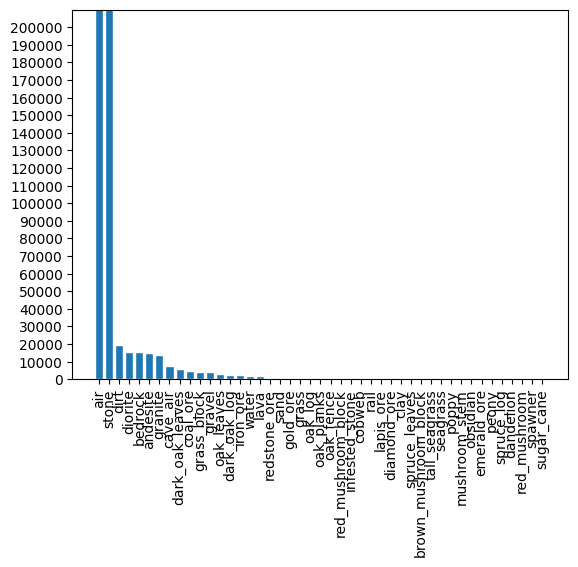

In [4]:
import matplotlib.pyplot as plt 
import numpy as np
# make data:
x = df["Tag"].value_counts().axes[0]
y = df["Tag"].value_counts()
print(y)
# plot
fig, ax = plt.subplots()

ax.bar(x, y, width=0.8, edgecolor="white")

ax.set(xticks=np.arange(0, len(x)),
       ylim=(0, 210000), yticks=np.arange(0, 210000,10000))

plt.xticks(rotation=90)
plt.show()

- De este gráfico vemos que hay un gran porcentaje del mapa que esta formado por bloques de aire y bloques piedra. Esto nos lleva a pensar que la cantidad de bloques esta muy desproporcionada es decir que tenemos un conjunto de datos desbalanceado.

### Distribución de los bloques de aire en el mapa

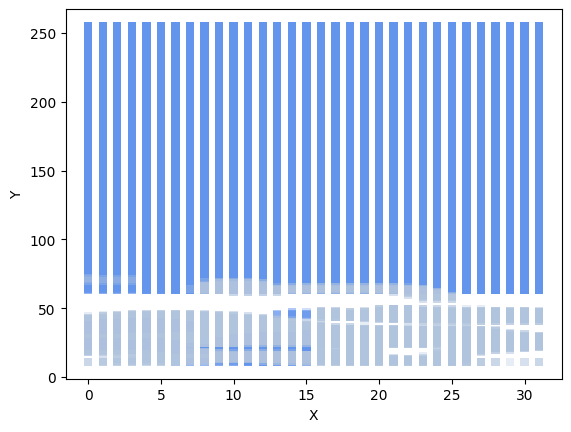

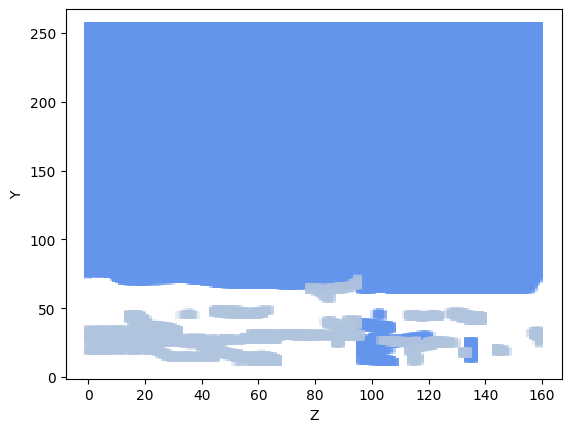

In [5]:
import matplotlib.pyplot as plt 
#Air block scatter plot
fig, ax = plt.subplots()
for lab in ["air", "cave_air"]:
    block = df[df.Tag == lab]
    x = block.X + block.CX*16 # coordenada absoluta
    y = block.Y 
    if lab == "air":
        color = "cornflowerblue"
    else:
        color = "lightsteelblue"
    ax.scatter(x, y, c=color, label=lab,
               alpha=0.3, edgecolors='none',marker="s")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


fig, ax = plt.subplots()
for lab in ["air", "cave_air"]:
    block = df[df.Tag == lab]
    z = block.Z + block.CZ*16 # coordenada absoluta
    y = block.Y 
    if lab == "air":
        color = "cornflowerblue"
    else:
        color = "lightsteelblue"
    ax.scatter(z, y, c=color, label=lab,
               alpha=0.3, edgecolors='none',marker="s")
plt.xlabel("Z")
plt.ylabel("Y")
plt.show()

- En estos gráficos podemos observar la distribución de los bloques de *aire* en azul y *aire de cueva* en color mas grisáceo. Se ve que a partir del la altura $Y = 70$ hay una gran cantidad de bloques de aire, estos corresponderían con el exterior, el cielo y el aire entre los arboles.

Como datos apartados podemos ver que hay bloques de *aire* debajo de la altura $Y = 70$. Estos bloques se encuentran en dentro de la grieta que se puede ver bajo tierra. También podemos ver que hay una porción de aire de cueva muy cercano a la superficie que corresponde con la entrada a alguna cueva desde la superficie.

### Distribución de la lava y el agua en el mapa

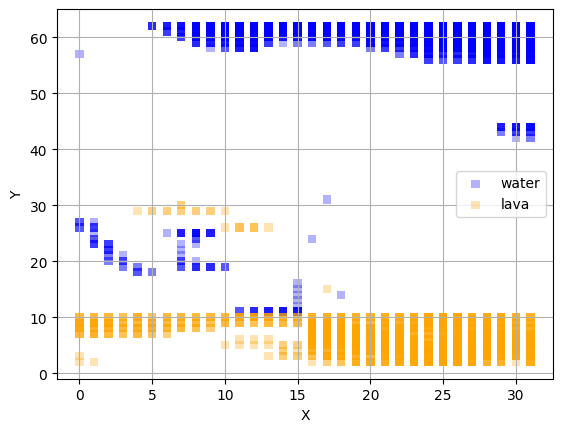

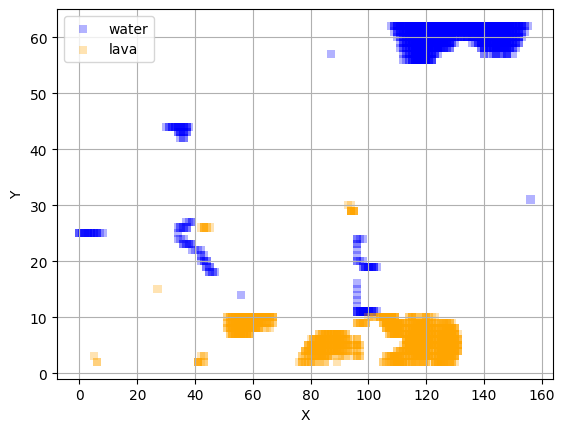

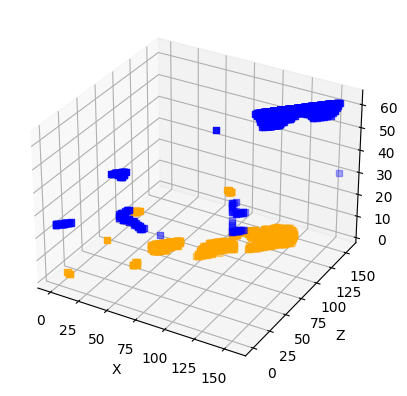

In [6]:
import numpy as np
import matplotlib.pyplot as plt
#lava and water scatter plot x and y
fig, ax = plt.subplots()
block = df
for lab in ["water", "lava"]:
    block = df[df.Tag == lab]
    x = block.X + block.CX*16 # coordenada absoluta
    y = block.Y 
    if lab == "water":
        color = "blue"
    else:
        color = "orange"
    ax.scatter(x, y, c=color, label=lab,
               alpha=0.3, edgecolors='none',marker="s")
ax.legend()
ax.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
#lava and water scatter plot z and y
fig, ax = plt.subplots()
block = df
for lab in ["water", "lava"]:
    block = df[df.Tag == lab]
    z = block.Z + block.CZ*16 # coordenada absoluta
    y = block.Y 
    if lab == "water":
        color = "blue"
    else:
        color = "orange"
    ax.scatter(z, y, c=color, label=lab,
               alpha=0.3, edgecolors='none',marker="s")
ax.legend()
ax.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
#lava and water scatter plot 3d
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

for lab in ["water", "lava"]:
    block = df[df.Tag == lab]
    x = block.Z + block.CZ*16 # coordenada absoluta
    y = block.Y 
    z = block.Z + block.CZ*16 # coordenada absoluta
    if lab == "water":
        color = "blue"
    else:
        color = "orange"
    ax.scatter(x,z,y, c=color,marker="s")
plt.xlabel("X")
plt.ylabel("Z")    
plt.show()

- Se puede Interpretar de estos gráficos que hay más *lava* mientras mas profundo o hacia abajo se va en el mapa. También se puede apreciar que el agua en las cuevas o bajo tierra tiende a desplazarse hacia abajo, mientras que la *lava* se acumula en grandes cantidades siempre bajo tierra.
Como casos apartados podemos ve que hay un gran cúmulo de bloques de *agua* muy en la superficie que corresponde con el rio que se puede apreciar en las imágenes de arriba. También hay un gran cúmulo de *lava* que corresponde con el fondo de la grieta observada.

### Distribución de tierra y arboles en el mapa

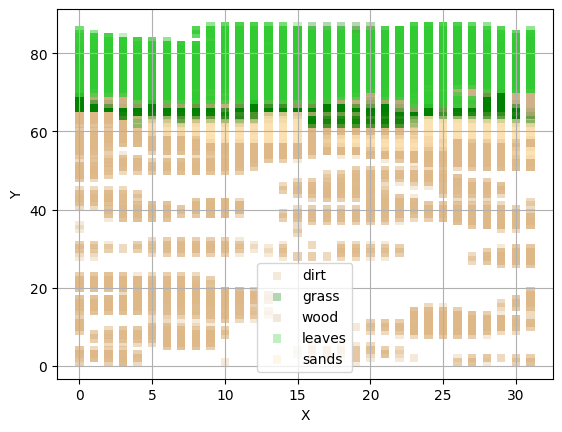

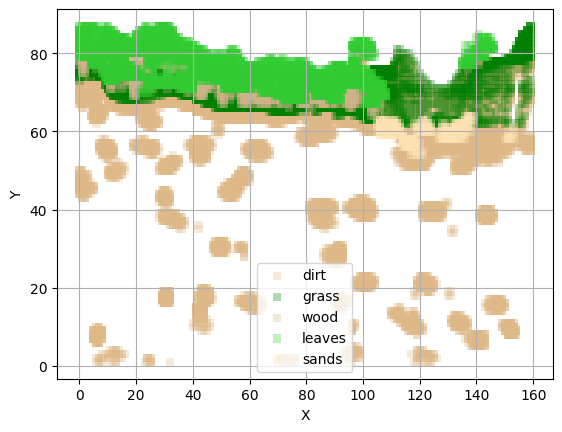

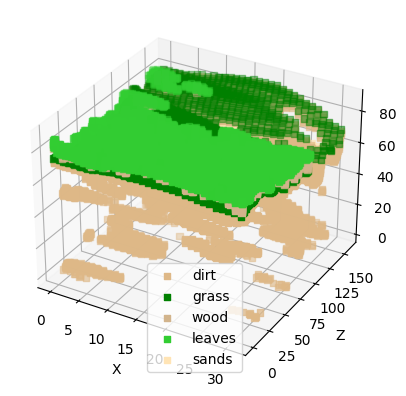

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#lava and water scatter plot x and y
#2D Plot
for dim in range(0,3):
    if(dim ==2):
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    else:
        fig, ax = plt.subplots()
    for lab in [['dirt'],['grass_block'],['oak_log','dark_oak_log','spruce_log'],['oak_leaves','dark_oak_leaves','spruce_leaves'],['sand','clay']]:
        block = df[df.Tag == lab[0]].copy()
        for i in range(1,len(lab)):
            block = block.merge(df[df.Tag == lab[i]],"outer")
        z = block.Z + block.CZ*16 # coordenada absoluta
        x = block.X + block.CX*16 # coordenada absoluta
        y = block.Y
        
        if lab[0] == "dirt":
            color = "burlywood"
            labName = "dirt"
        elif lab[0] == "grass_block":
            color = "green"
            labName = "grass"
        elif lab[0] == "oak_log":
            color = "tan"
            labName = "wood"
        elif lab[0] == "oak_leaves":
            color = "limegreen"
            labName = "leaves"
        elif lab[0] == "sand":
            color = "moccasin"
            labName = "sands"
        else:
            color = "white"
            labName = "None"
        if(dim == 0):
            ax.scatter(x, y, c=color, label=labName,alpha=0.3, edgecolors='none',marker="s")
            plt.xlabel("X")
            plt.ylabel("Y")
        elif(dim == 1):
            ax.scatter(z, y, c=color, label=labName,alpha=0.3, edgecolors='none',marker="s")
            plt.xlabel("X")
            plt.ylabel("Y")
        elif(dim == 2):
            ax.scatter(x,z,y,label=labName, c=color,marker="s")
            plt.xlabel("X")
            plt.ylabel("Z")
    ax.grid(True)
    ax.legend()
    plt.show()

- En estos gráficos podemos ver la distribución de la tierra,los arboles con sus hojas,la arena y arcilla. Lo más destacable de estos gráficos es que se puede ver que los troncos y hojas de los arboles están separados del suelo y la piedra por dos capas, la primera capa consiste de los bloques con pasto, y la segunda de varios bloques de tierra. 

- También se puede ver que donde hay arena no existen arboles por encima y también esta separada de las piedras por una capa de tierra. Si observamos bien la parte del mapa sin arboles es el valle donde se encuentra el rio y toda la arena y grava se encuentra principalmente alrededor y debjo de el.

- Finalmente la tierra se distribuye en cúmulos entre la piedra y se extiende prácticamente hasta las capas mas profundas.

## Detección de Outliers o datos espaciales apartados

Un *dato espacial aparatado* es un objeto especialmente referenciado cuyos atributos no-espaciales tienen valores que difieren significativamente de aquellos otros objetos que son vecinos.  

Existen dos tipos de metodos para la detección *valores apartados* en datos espaciales:
- **Graphical test** (Prueba gráfica): Metodos de ejemplo incluye el *variogram cloud* y el *Moran scatterplots*.
- **Quantitative test** (Prueba cuantitativa): proveen una prueba precisa para la distinción de los datos apartados. los *Scatterplots* son representativos de esta técnica.

Un **variogram-cloud** muestra puntos de datos relacionados por una relación de vecindad. por cada par de localizaciones, se plotea la raíz cuadrada de la diferencia absoluta entre los valores de los atributos de las localizaciones contra la distancia Euclideana entre las localizaciones. En conjuntos de datos que exhiben una fuerte dependencia espacial, la varianza en la diferencia entre atributos incrementara a medida que incrementa la distancia entre localizaciones.
Localizaciones que están cercanas una de la otra, pero tienen gran diferencia en sus atributos, deberían indicar un dato apartado, incluso si los valores de ambas localizaciones puedan aparentar ser razonables cuando se examinan los datos no espaciales.


In [ ]:
from outlierDetection import outilerDetection as od
atts  = df.Tag.unique().tolist();
#Cuenta la cantidad de bloques en ventanas de 4x4x4
blocks = od.countBlocks(4,4,4,df,atts);
blocks.to_csv("..\\..\\Data\\blockCount.csv",sep=";");

In [ ]:
from outlierDetection import outilerDetection as od
import matplotlib.pyplot as plt
import pandas as pd
atts  = df.Tag.unique().tolist();
blocks = pd.read_csv("..\\..\\Data\\chunkBlockCount.csv",sep=";");
blocks = blocks.drop(blocks.columns[0],axis=1)

fig,ax = od.variogramCloud(blocks,atts);
fig.show()

- Debido a que los vecindarios, ventanas o en este caso *chunks* se encuentran de manera equidistante entre si, no es util utilizar métodos que sirven para la detección de datos apartados teniendo en cuenta el espacio. Debido a que las distancias entre dos bloques se tienden a repetir se puede ver que hay un patron en la distribución de los puntos en los gráficos. Pero no es claro donde existen datos apartados y donde no. 



## Creación de transacciones a partir de datos espaciales

## Window centirc model

## Transacciones de ventanas de 4x4x4 sin solapamiento

In [3]:
#preprocesamiento Windows metric model
from preprocess import Preprocess
#TAMAÑO DE VENTANAS 4x4x4 bloques
atts  = df.Tag.unique().tolist();
transactions : pd.DataFrame = Preprocess.windowModel(4,4,4,atts,df,False,False);
print(transactions)
transactions.to_csv("..\\..\\Data\\transactions4x4x4.csv",sep=";");

     Section   SubSection  bedrock  stone  gold_ore  diorite  andesite  \
0      (0,0)      (0,0,0)     True   True      True     True      True   
1      (0,0)     (0,64,0)    False   True     False     True     False   
2      (0,0)    (0,128,0)    False  False     False    False     False   
3      (0,0)    (0,192,0)    False  False     False    False     False   
4      (0,0)      (0,0,4)     True   True     False     True      True   
...      ...          ...      ...    ...       ...      ...       ...   
1275   (1,9)   (12,192,8)    False  False     False    False     False   
1276   (1,9)    (12,0,12)     True   True     False     True      True   
1277   (1,9)   (12,64,12)    False   True     False     True      True   
1278   (1,9)  (12,128,12)    False  False     False    False     False   
1279   (1,9)  (12,192,12)    False  False     False    False     False   

      coal_ore   dirt  grass_block  ...   sand   clay  spruce_leaves  \
0         True  False        False  ...

In [8]:
# correr Apriori
import pandas as pd
import apriori as ap
transactions = pd.read_csv("..\\..\\Data\\transactions4x4x4.csv",sep=";");
transactions = transactions.drop(transactions.columns[0],axis=1);
rules=ap.apriori(transactions,0.05,0.0);
rules.to_csv("..\\..\\Data\\windowRules5x0.csv",sep=";");

In [12]:
#Graficar
import pandas as pd
import postprocess as pp
rules = pd.read_csv("..\\..\\Data\\windowRules5x0.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
#reglas
print(rules)
pp.toNeo("windowRules5x0");

                                            antecedants  =>     consequents  \
0                                           ['granite']  =>        ['lava']   
1                                              ['lava']  =>     ['granite']   
2                                          ['cave_air']  =>       ['stone']   
3                                             ['stone']  =>    ['cave_air']   
4                                               ['air']  =>       ['stone']   
...                                                 ...  ..             ...   
3226  ['diorite', 'andesite', 'coal_ore', 'bedrock',...  =>  ['oak_planks']   
3227  ['diorite', 'oak_planks', 'coal_ore', 'bedrock...  =>    ['andesite']   
3228  ['diorite', 'oak_planks', 'andesite', 'bedrock...  =>    ['coal_ore']   
3229  ['diorite', 'oak_planks', 'andesite', 'coal_or...  =>     ['bedrock']   
3230  ['diorite', 'oak_planks', 'andesite', 'coal_or...  =>    ['cave_air']   

       support  confidence      lift  frequency  ef

![WGRR](../../Images/Graphs/windowsRulesGeneralGraph.png)

In [4]:
#Posprocesamiento
import pandas as pd
import postprocess as pp
rules = pd.read_csv("..\\..\\Data\\windowRules5x0.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
DS : pd.DataFrame;
Non_DS : pd.DataFrame;
DS, Non_DS  = pp.pruneRules(rules,s=0.05);
DS.to_csv("..\\..\\Data\\windowRules(DS).csv",sep=";");
#Non_DS.to_csv("..\\..\\Data\\windowRules(non_DS).csv",sep=";");
pp.toNeo("windowRules(DS)");

!["DS rules"](../../Images/Graphs/windowsDSGraph.png)

### Análisis de las reglas obtenidas

Para la generación de estas reglas pasamos como parametro un soporte minimo de 0.05 y una confinaza de 0, ya que para el dominio de nuestro problema los que estamos buscando es la mayor cantidad de reglas que representen el espació a pesar de que su frecuencia de aparición se muy pequeña. Es en este caso que vemos que el algoritmo apriori resulta tener una una limitación al definir estos parametros y es recomendable buscar otro tipo de algoritmos para la mineria de reglas de asociación.

Realmente este enfoque para modelar las transacciones no nos resulta de gran interes, ya que simplementa nos resulta en un resumen que indica que bloque existe en una ventada dado que otro existe. Si bien es notorio que existe un patron. Por el tamaño de las ventanas y el hecho de que no se superponen entre sí, no podemos los podemos obtener de manera clara. No resulta de un modelo que nos permita obtener las reglas que se esperan.

Observando el gráfico 1:  
Observando el gráfico 2:

### Reference feature centric model

Transacciones con ventanas de la forma cruz con 7 bloques, se pueden visualizar de la siguiente manera:  
![Cruz](../../Images/Croos.png)  
Con este tipo de modelado de transacciones podemos obtener reglas que tienen una forma más cercana a las reglas que esperamos generar.

In [6]:
#Path del CSV
csvPath = "..\\..\\Data\\chunks.csv"
#Lectura del CSV
import pandas as pd
df = pd.read_csv(csvPath,delimiter=";",lineterminator="\n")
df = df.rename(columns={"ChunkX": "CX","ChunkZ\r": "CZ"}, errors="raise")
print(df)

           Bid   X    Y   Z      Tag  CX  CZ
0            1   0    0   0  bedrock   0   0
1            2   0    1   0  bedrock   0   0
2            3   0    2   0  bedrock   0   0
3            4   0    3   0    stone   0   0
4            5   0    4   0    stone   0   0
...        ...  ..  ...  ..      ...  ..  ..
1310715  65532  15  251  15      air   1   9
1310716  65533  15  252  15      air   1   9
1310717  65534  15  253  15      air   1   9
1310718  65535  15  254  15      air   1   9
1310719  65536  15  255  15      air   1   9

[1310720 rows x 7 columns]


### Atributo de referencia **diamante**

In [ ]:
from preprocess import Preprocess
atts  = df.Tag.unique().tolist();
list = ['diamond_ore']
transactions : pd.DataFrame = Preprocess.referenceFeatureModel(atts,df,list,"");
transactions.to_csv("..\\..\\Data\\transactionsDiamon.csv",sep=";");

In [8]:
import pandas as pd
import apriori as ap
transactions = pd.read_csv("..\\..\\Data\\transactionsDiamon.csv",sep=";");
transactions = transactions.drop(transactions.columns[0],axis=1);
rules = ap.apriori(transactions,0.05,0.00);
rules.to_csv("..\\..\\Data\\rulesDiamon5x00.csv",sep=";");

In [8]:
import apriori as ap
import pandas as pd
rules = pd.read_csv("..\\..\\Data\\rulesDiamon5x00.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
print(rules)

                                           antecedants  =>  \
0                       ['esta a la derecha de stone']  =>   
1                            ['abajo hay diamond_ore']  =>   
2                    [' esta a la izquierda de stone']  =>   
3                              ['delante tiene stone']  =>   
4                    [' esta a la izquierda de stone']  =>   
..                                                 ...  ..   
962  ['delante tiene diamond_ore', 'arriba hay ston...  =>   
963  ['detrás tiene stone', 'arriba hay stone', 'es...  =>   
964  ['detrás tiene stone', 'delante tiene diamond_...  =>   
965  ['detrás tiene stone', 'delante tiene diamond_...  =>   
966  ['detrás tiene stone', 'delante tiene diamond_...  =>   

                                 consequents   support  confidence       lift  
0                  ['abajo hay diamond_ore']  0.160000    0.307692   1.923077  
1             ['esta a la derecha de stone']  0.160000    0.705882   4.411765  
2              

In [ ]:
#Graficar
import pandas as pd
import postprocess as pp
rules = pd.read_csv("..\\..\\Data\\rulesDiamon5x00.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
#reglas
print(rules)
pp.toNeo("rulesDiamon5x00");

                                           antecedants  =>  \
0                       ['esta a la derecha de stone']  =>   
1                            ['abajo hay diamond_ore']  =>   
2                    [' esta a la izquierda de stone']  =>   
3                              ['delante tiene stone']  =>   
4                    [' esta a la izquierda de stone']  =>   
..                                                 ...  ..   
962  ['delante tiene diamond_ore', 'arriba hay ston...  =>   
963  ['detrás tiene stone', 'arriba hay stone', 'es...  =>   
964  ['detrás tiene stone', 'delante tiene diamond_...  =>   
965  ['detrás tiene stone', 'delante tiene diamond_...  =>   
966  ['detrás tiene stone', 'delante tiene diamond_...  =>   

                                 consequents   support  confidence       lift  
0                  ['abajo hay diamond_ore']  0.160000    0.307692   1.923077  
1             ['esta a la derecha de stone']  0.160000    0.705882   4.411765  
2              

!["Grafo de reglas generales"](../../Images/Graphs/diamonRulesGeneralGraph.png)

In [1]:
#Posprocesamiento
import pandas as pd
import postprocess as pp
rules = pd.read_csv("..\\..\\Data\\rulesDiamon5x00.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
DS : pd.DataFrame;
Non_DS : pd.DataFrame;
DS, Non_DS  = pp.pruneRules(rules,s=0.05);
DS.to_csv("..\\..\\Data\\diamonRules(DS).csv",sep=";");
#Non_DS.to_csv("..\\..\\Data\\windowRules(non_DS).csv",sep=";");
pp.toNeo("diamonRules(DS)");

c:\Users\MrtC101\Desktop\Ciencias_en_Computacion\Cursado\3.2Inteligencia Artificial I\repositorio-proyecto-final\proyecto_final\code\python\postprocess.py:56: RuntimeWarning: invalid value encountered in scalar divide
  res+= math.pow(m[i][j] - es[i][j],2) / es[i][j];
c:\Users\MrtC101\Desktop\Ciencias_en_Computacion\Cursado\3.2Inteligencia Artificial I\repositorio-proyecto-final\proyecto_final\code\python\postprocess.py:56: RuntimeWarning: invalid value encountered in scalar divide
  res+= math.pow(m[i][j] - es[i][j],2) / es[i][j];
c:\Users\MrtC101\Desktop\Ciencias_en_Computacion\Cursado\3.2Inteligencia Artificial I\repositorio-proyecto-final\proyecto_final\code\python\postprocess.py:56: RuntimeWarning: invalid value encountered in scalar divide
  res+= math.pow(m[i][j] - es[i][j],2) / es[i][j];
c:\Users\MrtC101\Desktop\Ciencias_en_Computacion\Cursado\3.2Inteligencia Artificial I\repositorio-proyecto-final\proyecto_final\code\python\postprocess.py:56: RuntimeWarning: invalid value enco

![diamondDS](../../Images/Graphs/diamondDSGraph.png)

### Análisis de las Reglas
En este caso con el debido análisis se pueden detectar ciertos patrones al rededor de los bloques de diamante.
![](../../Images/Graphs/rulesDiamon25x50graph.png)

## Atributo de referencia **hojas y troncos**

In [ ]:
from preprocess import Preprocess
atts  = df.Tag.unique().tolist();
#intratable Arboles y hojas
trees = ["spruce_log","spruce_leaves","dark_oak_log","dark_oak_leaves","oak_log","oak_leaves"];
transactions : pd.DataFrame = Preprocess.referenceFeatureModel(atts,df,trees);
print(transactions)
transactions.to_csv("..\\..\\Data\\transactionsTrees.csv",sep=";");

In [2]:
import pandas as pd
import apriori as ap
transactions = pd.read_csv("..\\..\\Data\\transactionsTrees.csv",sep=";");
transactions = transactions.drop(transactions.columns[0],axis=1);
rules = ap.apriori(transactions,0.05,0.00);
rules.to_csv("..\\..\\Data\\rulesTrees5x00.csv",sep=";");
print(rules)

                                           antecedants  =>  \
0                          ['arriba hay dark_oak_log']  =>   
1                         ['esta a la derecha de air']  =>   
2                         ['delante tiene oak_leaves']  =>   
3                  ['esta a la derecha de oak_leaves']  =>   
4          [' esta a la izquierda de dark_oak_leaves']  =>   
..                                                 ...  ..   
759  ['abajo hay dark_oak_leaves', 'arriba hay dark...  =>   
760  [' esta a la izquierda de dark_oak_leaves', 'a...  =>   
761  ['esta a la derecha de dark_oak_leaves', 'arri...  =>   
762  ['esta a la derecha de dark_oak_leaves', ' est...  =>   
763  ['esta a la derecha de dark_oak_leaves', ' est...  =>   

                                     consequents   support  confidence  \
0                   ['esta a la derecha de air']  0.072587    0.422941   
1                    ['arriba hay dark_oak_log']  0.072587    0.357234   
2            ['esta a la derecha 

In [4]:
#Graficar
import pandas as pd
import postprocess as pp
rules = pd.read_csv("..\\..\\Data\\rulesTrees5x00.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
#reglas
print(rules)
pp.toNeo("rulesTrees5x00");

                                           antecedants  =>  \
0                                ['delante tiene air']  =>   
1                          ['arriba hay dark_oak_log']  =>   
2          [' esta a la izquierda de dark_oak_leaves']  =>   
3                                   ['arriba hay air']  =>   
4             ['esta a la derecha de dark_oak_leaves']  =>   
..                                                 ...  ..   
764  ['es dark_oak_leaves', 'esta a la derecha de d...  =>   
765  ['detrás tiene dark_oak_leaves', 'esta a la de...  =>   
766  ['detrás tiene dark_oak_leaves', 'es dark_oak_...  =>   
767  ['detrás tiene dark_oak_leaves', 'es dark_oak_...  =>   
768  ['detrás tiene dark_oak_leaves', 'es dark_oak_...  =>   

                                     consequents   support  confidence  \
0                    ['arriba hay dark_oak_log']  0.066777    0.344982   
1                          ['delante tiene air']  0.066777    0.389085   
2                             ['a

!["Grafo de reglas generales"](../../Images/Graphs/HojasyTroncosGeneralGraph.png)

In [3]:
#Posprocesamiento
import pandas as pd
import postprocess as pp
rules = pd.read_csv("..\\..\\Data\\rulesTrees5x00.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
DS : pd.DataFrame;
Non_DS : pd.DataFrame;
DS, Non_DS  = pp.pruneRules(rules,s=0.05);
DS.to_csv("..\\..\\Data\\treesRules(DS).csv",sep=";");
#Non_DS.to_csv("..\\..\\Data\\windowRules(non_DS).csv",sep=";");
pp.toNeo("treesRules(DS)");

![treesRules(DS)](../../Images/Graphs/treesDSGraph.png)

### Análisis de las Reglas
![](../../Images/Graphs/rulesTrees10x75graph.png)

## Atributo de referencia **bloque con pasto**

In [ ]:
from preprocess import Preprocess
atts  = df.Tag.unique().tolist();
#intratable Arboles y hojas
print(atts)
trees = ['grass_block'];
transactions : pd.DataFrame = Preprocess.referenceFeatureModel(atts,df,trees,"");
print(transactions)
transactions.to_csv("..\\..\\Data\\transactionsGrass.csv",sep=";");

In [4]:
import pandas as pd
import apriori as ap
transactions = pd.read_csv("..\\..\\Data\\transactionsGrass.csv",sep=";");
transactions = transactions.drop(transactions.columns[0],axis=1);
rules = ap.apriori(transactions,0.05,0.00);
rules.to_csv("..\\..\\Data\\rulesGrass5x00.csv",sep=";");
print(rules)

                                           antecedants  =>  \
0                                ['izquierda de dirt']  =>   
1                           ['derecha de grass_block']  =>   
2                                ['izquierda de dirt']  =>   
3                                        ['sobre air']  =>   
4                            ['detrás de grass_block']  =>   
..                                                 ...  ..   
681  ['es grass_block', 'delante de dirt', 'debajo ...  =>   
682  ['debajo dirt', 'detrás de dirt', 'delante de ...  =>   
683  ['es grass_block', 'detrás de dirt', 'delante ...  =>   
684  ['es grass_block', 'debajo dirt', 'delante de ...  =>   
685  ['es grass_block', 'debajo dirt', 'detrás de d...  =>   

                    consequents   support  confidence      lift  frequency  \
0    ['derecha de grass_block']  0.103482    0.727740  0.000290        425   
1         ['izquierda de dirt']  0.103482    0.169525  0.000290        425   
2                 ['s

In [5]:
#Graficar
import pandas as pd
import postprocess as pp
rules = pd.read_csv("..\\..\\Data\\rulesGrass5x00.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
#reglas
print(rules)
pp.toNeo("rulesGrass5x00");

                                           antecedants  =>  \
0                                      ['debajo dirt']  =>   
1                                ['izquierda de dirt']  =>   
2                                   ['delante de air']  =>   
3                         ['izquierda de grass_block']  =>   
4                                   ['delante de air']  =>   
..                                                 ...  ..   
815  ['es grass_block', 'debajo dirt', 'delante de ...  =>   
816  ['izquierda de grass_block', 'debajo dirt', 'd...  =>   
817  ['izquierda de grass_block', 'es grass_block',...  =>   
818  ['izquierda de grass_block', 'es grass_block',...  =>   
819  ['izquierda de grass_block', 'es grass_block',...  =>   

                      consequents   support  confidence       lift  
0           ['izquierda de dirt']  0.138787    0.140394   1.011576  
1                 ['debajo dirt']  0.138787    0.976027   7.032534  
2    ['izquierda de grass_block']  0.073776    0

!["Grafo de reglas generales"](../../Images/Graphs/grassRulesGeneralGraph.png)

In [5]:
#Posprocesamiento
import pandas as pd
import postprocess as pp
rules = pd.read_csv("..\\..\\Data\\rulesGrass5x00.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
DS : pd.DataFrame;
Non_DS : pd.DataFrame;
DS, Non_DS  = pp.pruneRules(rules,s=0.05);
DS.to_csv("..\\..\\Data\\grassRules(DS).csv",sep=";");
#Non_DS.to_csv("..\\..\\Data\\windowRules(non_DS).csv",sep=";");
pp.toNeo("grassRules(DS)");

c:\Users\MrtC101\Desktop\Ciencias_en_Computacion\Cursado\3.2Inteligencia Artificial I\repositorio-proyecto-final\proyecto_final\code\python\postprocess.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  res+= math.pow(m[i][j] - es[i][j],2) / es[i][j];
c:\Users\MrtC101\Desktop\Ciencias_en_Computacion\Cursado\3.2Inteligencia Artificial I\repositorio-proyecto-final\proyecto_final\code\python\postprocess.py:56: RuntimeWarning: invalid value encountered in scalar divide
  res+= math.pow(m[i][j] - es[i][j],2) / es[i][j];
c:\Users\MrtC101\Desktop\Ciencias_en_Computacion\Cursado\3.2Inteligencia Artificial I\repositorio-proyecto-final\proyecto_final\code\python\postprocess.py:56: RuntimeWarning: divide by zero encountered in scalar divide
  res+= math.pow(m[i][j] - es[i][j],2) / es[i][j];
c:\Users\MrtC101\Desktop\Ciencias_en_Computacion\Cursado\3.2Inteligencia Artificial I\repositorio-proyecto-final\proyecto_final\code\python\postprocess.py:56: RuntimeWarning: invalid value en

![grassDSgraph](../../Images/Graphs/grassDSGraph.png)

### Análisis de las Reglas
![](../../Images/Graphs/rulesGrass15x95graph.png)

### Combinación entre los modelos anteriores

Con los resultados obtenidos mediante los dos modelos anteriores, uno tendería querer combinar la forma que toman las reglas como resultado de el *reference feature centric model* y aplicarlo en todo el espacio como con el *window centric model*.

Debido a que la cantidad de tiempo necesario para generar las ventanas en cruz para cada bloque del mapa es grande, nos de dictaremos a el análisis y exploración de las reglas generadas para un solo chunk que son un total de $16x16x256 = 65536$  bloques.

Por lo tanto generaremos las transaccione para todos los bloques con ventanas tipo cruz que se superpondrán en todo el espacio.

In [2]:
#Path del CSV
csvPath = "..\\..\\Data\\chunks.csv"
#Lectura del CSV
import pandas as pd
df = pd.read_csv(csvPath,delimiter=";",lineterminator="\n")
df = df.rename(columns={"ChunkX": "CX","ChunkZ\r": "CZ"}, errors="raise")
from preprocess import Preprocess
atts  = df.Tag.unique().tolist();
#intratable Arboles y hojas
Preprocess.referenceFeatureModel(atts,df[(df.CX==0)&(df.CZ==0)],atts,"..\\..\\Data\\transactionsChunk00.csv");

0/65536|21:31:33|0:0:0
328/65536|21:31:36|0:0:3
656/65536|21:31:38|0:0:5
984/65536|21:31:41|0:0:8
1312/65536|21:31:44|0:0:11
1640/65536|21:31:47|0:0:14
1968/65536|21:31:50|0:0:17
2296/65536|21:31:52|0:0:19
2624/65536|21:31:55|0:0:22
2952/65536|21:31:58|0:0:25
3280/65536|21:32:0|0:0:27
3608/65536|21:32:3|0:0:30
3936/65536|21:32:6|0:0:33
4264/65536|21:32:8|0:0:35
4592/65536|21:32:11|0:0:38
4920/65536|21:32:13|0:0:41
5248/65536|21:32:16|0:0:43
5576/65536|21:32:19|0:0:46
5904/65536|21:32:21|0:0:48
6232/65536|21:32:24|0:0:51
6560/65536|21:32:27|0:0:54
6888/65536|21:32:29|0:0:56
7216/65536|21:32:32|0:0:59
7544/65536|21:32:34|0:1:2
7872/65536|21:32:37|0:1:4
8200/65536|21:32:40|0:1:7
8528/65536|21:32:42|0:1:9
8856/65536|21:32:45|0:1:12
9184/65536|21:32:48|0:1:15
9512/65536|21:32:51|0:1:18
9840/65536|21:32:55|0:1:22
10168/65536|21:32:58|0:1:25
10496/65536|21:33:1|0:1:28
10824/65536|21:33:4|0:1:32
11152/65536|21:33:8|0:1:35
11480/65536|21:33:11|0:1:38
11808/65536|21:33:14|0:1:41
12136/65536|21:3

In [3]:
import pandas as pd
print(df[(df.CX==0)&(df.CZ==0)].Tag.value_counts())
transactions = pd.read_csv("..\\..\\Data\\transactionsChunk00.csv",sep=";");
transactions = transactions.drop(transactions.columns[0],axis=1);

air                45483
stone              13436
dirt                1086
diorite             1036
andesite             871
bedrock              774
granite              617
cave_air             470
oak_leaves           354
dark_oak_leaves      345
grass_block          240
coal_ore             225
gravel               148
iron_ore             124
dark_oak_log          99
oak_fence             44
oak_planks            37
oak_log               37
rail                  23
water                 22
redstone_ore          20
gold_ore              11
cobweb                10
poppy                 10
grass                  9
lava                   3
lapis_ore              2
Name: Tag, dtype: int64


In [6]:
import pandas as pd
import apriori as ap
transactions = pd.read_csv("..\\..\\Data\\transactionsChunk00.csv",sep=";");
transactions = transactions.drop(transactions.columns[0],axis=1);
rules = ap.apriori(transactions,0.05,0.00);
rules.to_csv("..\\..\\Data\\chunk00rules5x00.csv",sep=";");
print(rules)

                                           antecedants  =>  \
0                    [' esta a la izquierda de stone']  =>   
1                       ['esta a la derecha de stone']  =>   
2                                           ['es air']  =>   
3                         ['esta a la derecha de air']  =>   
4                    [' esta a la izquierda de stone']  =>   
..                                                 ...  ..   
284  ['esta a la derecha de air', 'arriba hay air',...  =>   
285  ['esta a la derecha de stone', 'es stone', 'de...  =>   
286  ['detrás tiene stone', 'es stone', 'delante ti...  =>   
287  ['detrás tiene stone', 'esta a la derecha de s...  =>   
288  ['detrás tiene stone', 'esta a la derecha de s...  =>   

                           consequents   support  confidence      lift  \
0       ['esta a la derecha de stone']  0.155380    0.805553  0.000065   
1    [' esta a la izquierda de stone']  0.155380    0.815619  0.000065   
2         ['esta a la derecha de 

In [7]:
#Graficar
import pandas as pd
import postprocess as pp
rules = pd.read_csv("..\\..\\Data\\chunk00rules5x00.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
#reglas
print(rules)
pp.toNeo("chunk00rules5x00");

                                           antecedants  =>  \
0                                    ['abajo hay air']  =>   
1                      [' esta a la izquierda de air']  =>   
2                                 ['detrás tiene air']  =>   
3                                   ['arriba hay air']  =>   
4                       ['esta a la derecha de stone']  =>   
..                                                 ...  ..   
448  ['es air', ' esta a la izquierda de air', 'del...  =>   
449  ['arriba hay air', ' esta a la izquierda de ai...  =>   
450  ['arriba hay air', 'es air', 'delante tiene ai...  =>   
451  ['arriba hay air', 'es air', ' esta a la izqui...  =>   
452  ['arriba hay air', 'es air', ' esta a la izqui...  =>   

                         consequents   support  confidence      lift  \
0    [' esta a la izquierda de air']  0.642914    0.931612  1.449046   
1                  ['abajo hay air']  0.642914    0.988574  1.537646   
2                 ['arriba hay air']  0

!["Grafo de reglas generales"](../../Images/Graphs/chunkRulesGeneralGraph.png)

In [7]:
#Posprocesamiento
import pandas as pd
import postprocess as pp
rules = pd.read_csv("..\\..\\Data\\chunk00rules5x00.csv",sep=";");
rules = rules.drop(rules.columns[0],axis=1);
DS : pd.DataFrame;
Non_DS : pd.DataFrame;
DS, Non_DS  = pp.pruneRules(rules,s=0.05);
DS.to_csv("..\\..\\Data\\chunkRules(DS).csv",sep=";");
#Non_DS.to_csv("..\\..\\Data\\windowRules(non_DS).csv",sep=";");
pp.toNeo("chunkRules(DS)");

![chunkDSgraph](../../Images/Graphs/chunkDSGraph.png)

# Resultados y Conclusión

Utilizar el algoritmo **Apriori** para esta tarea no es la mejor opción. En este caso el tener un soporte mínimo resulta mas en una limitación que en una restricción. El soporte mínimo no nos permite observar en detalle aquellos patrones de posicionamiento de bloques que están poco presentes en el mapa. El hecho de que existan menor cantidad de patrones de algún tipo no les quita importancia respecto a aquellos que aparecen en gran cantidad como los patrones relacionados con los bloques de aire,piedra o tierra que son los bloques que más aparecen.

In [ ]:
#Resultados


# Bibliografía y Papers relacionados 

## Fuentes Primarias

### Data Mining

+ [Data Mining and Knowledge Discovery Handbook](https://link.springer.com/book/10.1007/b107408)

### Spatial Data Mining

+ [Spatial Data Mining_ Theory and Application_Deren L., Shuliang W., Deyi L](https://link.springer.com/book/10.1007/978-3-662-48538-5)

+ [Discovering Spatial Co-location Patterns](https://link.springer.com/chapter/10.1007/3-540-47724-1_13)

## Fuentes Secundarios

### Association Rules mining ##

+ [Métricas para reglas de association](https://towardsdatascience.com/association-rules-2-aa9a77241654)
+ [Priori en R](https://www.geeksforgeeks.org/association-rule-mining-in-r-programming/#:~:text=Association%20Rule%20Mining%20in%20R%20Language%20is%20an%20Unsupervised%20Non,in%20a%20transaction%20or%20relation.)
+ [Lista de algoritmos para minería de reglas de asociación](https://personal.ntu.edu.sg/assourav/Unpublished/UP-ARMSurvey.pdf)

### Spacial Association Rules mining ##

+ [Enhancing spatial association rule mining in geographic databases](https://www.lume.ufrgs.br/handle/10183/7841)
+ [POWERPOINT Spatial Association Rules](https://www.ismll.uni-hildesheim.de/lehre/spatial-09w/script/association_web.pdf)
+ [Papers del Power anterior](http://www.spatial.cs.umn.edu/paper_list.html)
+ [SPADA system for spatial association rules mining on spatial databases](https://edz.bib.uni-mannheim.de/www-edz/pdf/eurostat/02/KS-CS-02-001-EN-N-EN.pdf#page=26)
+ [Discovering spatial interaction patterns of near repeat crime by spatial association rules mining](https://www.nature.com/articles/s41598-020-74248-w)
+ [Exploring spatial data](https://libraries.mit.edu/files/gis/exploring_spatial_patterns_iap2013.pdf)

### Procedural generation ##

+ [DISEÑO DE ALGORITMO DE GENERACIÓN PROCEDURAL ENFOCADO A VIDEOJUEGOS](https://repositorio.usm.cl/bitstream/handle/11673/49444/3560902038911UTFSM.pdf?sequence=1&isAllowed=y)

### Minecraft related content ##

+ [The World Generation of Minecraft](https://www.alanzucconi.com/2022/06/05/minecraft-world-generation/)
+ [JS chunk visualizer](https://pessimistress.github.io/minecraft/)
+ [I Wrote a 3D Chunk Visualizer for Minecraft](https://www.youtube.com/watch?v=fpGsOdxcU2M&ab_channel=ParametricCamp)
+ [An easy to use and fast Minecraft world viewer](https://unmined.net)
+ [enkiMI Minecraft 3D editor](https://www.reddit.com/r/VoxelGameDev/comments/8c4a67/a_better_way_to_extract_minecraft_data/)
+ [Minecraft Region file format](https://minecraft.fandom.com/wiki/Region_file_format)
+ [Minecraft Region file Wikipedia](https://wiki.vg/Region_Files)
+ [Formato NBT](https://minecraft.fandom.com/es/wiki/Formato_NBT)
+ [Anvil Parser](https://github.com/matcool/anvil-parser)